In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage import io 
import matplotlib.pyplot as plt
import torch
import glob
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)
from sklearn.model_selection import train_test_split

path = "C:/Users/simon/OneDrive/Documents/munch project/"

In [2]:
# Fonctions personnalisées

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [3]:
# Loading of painting in files 
#images = [cv2.imread(file) for file in glob.glob(path+"/munch_paintings/*.jpg")]

In [4]:
# Taille des images en pixels
IMAGE_SIZE = 256
# Nombre de canaux de couleur (3 pour les images en couleur, 1 pour les images en noir et blanc)
CHANNELS = 3
# Taille du lot d'entraînement (nombre d'images dans chaque lot)
BATCH_SIZE = 64
# Nombre de caractéristiques dans l'espace latent
NUM_FEATURES = 128
# Dimension de l'espace latent (représentation latente des données)
Z_DIM = 200
# Taux d'apprentissage du modèle
LEARNING_RATE = 0.0005
# Nombre d'époques d'entraînement
EPOCHS = 30
# Paramètre de régularisation (facteur de la divergence KL dans la perte VAE)
BETA = 2000
# Option pour charger un modèle pré-entraîné (True pour charger, False pour entraîner à partir de zéro)
LOAD_MODEL = False
# Définissez le chemin complet
data_dir = "C:/Users/simon/OneDrive/Documents/munch project/"

In [5]:
# Charger les données en utilisant la variable du chemin d'accès
images = utils.image_dataset_from_directory(
    path + "/munch_paintings",  # Concaténer data_dir avec "/img_align_celeba" pour obtenir le chemin complet
    labels=None,                    # Aucune étiquette n'est utilisée
    color_mode="rgb",               # Mode couleur RVB
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # Taille des images
    batch_size=BATCH_SIZE,           # Taille du lot
    shuffle=True,                   # Mélanger les données
    seed=42,                        # Graine pour la reproductibilité
    interpolation="bilinear"        # Méthode d'interpolation pour le redimensionnement
)

Found 1745 files belonging to 1 classes.


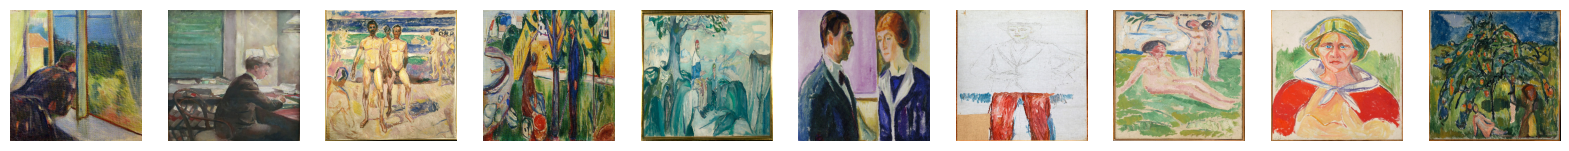

In [6]:
# Affichage d'une image pour vérifier l'import
# Échantillonne un lot de données à partir de l'ensemble de données d'entraînement
train_sample = sample_batch(images)

# Affiche quelques tableaux du dataset
display(train_sample, cmap=None)

# Preprocessing

In [7]:
def preprocess(img):
    # Conversion des valeurs de l'image en flottant et mise à l'échelle entre 0 et 1
    img = tf.cast(img, "float32") / 255.0
    img = (tf.cast(img, "float32") - 0.5) * 2
    return img

# Application de la fonction de prétraitement aux données d'entraînement
data = images.map(lambda x: preprocess(x))

## VAE

In [8]:
# Classe de couche personnalisée pour l'échantillonnage dans le VAE
class Sampling(layers.Layer):
    def call(self, inputs):
        """
        Effectue l'échantillonnage pour générer des échantillons à partir des moyennes et des log-variances latentes.

        Args:
            inputs (tuple): Un tuple contenant les tenseurs z_mean et z_log_var.

        Returns:
            z (tf.Tensor): Le tenseur résultant de l'échantillonnage.
        """
        # Extraction des moyennes et des log-variances
        z_mean, z_log_var = inputs

        # Obtention de la taille du lot (batch) et de la dimension latente
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        # Génération d'un échantillon epsilon à partir d'une distribution normale
        epsilon = K.random_normal(shape=(batch, dim))

        # Calcul de l'échantillon z en utilisant les moyennes, les log-variances et epsilon
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        return z

In [9]:
shape_before_flattening = data.element_spec.shape
#shape_before_flattening = shape_before_flattening.replace(None, 128)
#shape_before_flattening = (128,256,256,3)
print(shape_before_flattening)

(None, 256, 256, 3)


In [10]:
# Définition de l'entrée du modèle d'encodage
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)

# Construction des couches de convolution et de normalisation
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Ajout de couches de convolution, de normalisation et de ReLU supplémentaires
# Cela permet d'apprendre des caractéristiques à différentes échelles
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Aplatit les activations en un vecteur
x = layers.Flatten()(x)

# Projection des activations dans l'espace latent (z_mean et z_log_var)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

# Utilisation de la classe personnalisée Sampling pour l'échantillonnage
z = Sampling()([z_mean, z_log_var])

# Création du modèle d'encodage
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Affichage du résumé du modèle d'encodage
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 128)        3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 128)        512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)        0         ['batch_normalization[0]

In [11]:
tf.keras.backend.clear_session()

In [12]:
# Décodeur
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")

# Projection des activations latentes dans l'espace avant l'aplatissement
x = layers.Dense(256)(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Rétablissement de la forme avant l'aplatissement
x = layers.Reshape((8,8,4))(x)

# Utilisation de couches de déconvolution pour générer une sortie
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Couche de sortie pour générer l'image décodée
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)

# Création du modèle de décodage
decoder = models.Model(decoder_input, decoder_output)

# Affichage du résumé du modèle de décodage
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       4736      
 anspose)                                                    

In [13]:
# Classe VAE (Variational Autoencoder)
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        """
        Initialise un modèle Variational Autoencoder (VAE).

        Args:
            encoder (tf.keras.models.Model): Le modèle de l'encodeur.
            decoder (tf.keras.models.Model): Le modèle du décodeur.
            **kwargs: Arguments supplémentaires pour la classe parente.
        """
        super(VAE, self).__init__(**kwargs)
        
        # Initialisation de l'encodeur et du décodeur
        self.encoder = encoder
        self.decoder = decoder
        
        # Création de traqueurs pour les métriques
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """
        Métriques à surveiller pendant l'entraînement.

        Returns:
            list: Liste de métriques à surveiller.
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """
        Appelle le modèle sur une entrée particulière.

        Args:
            inputs: Les données d'entrée.

        Returns:
            tuple: Un tuple contenant les moyennes latentes, les log-variances latentes et les reconstructions.
        """
        # Appel de l'encodeur et du décodeur
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """
        Étape exécutée lors de l'entraînement.

        Args:
            data: Les données d'entraînement.

        Returns:
            dict: Un dictionnaire contenant les métriques de perte.
        """
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            
            # Calcul de la perte de reconstruction
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            
            # Calcul de la perte de divergence de Kullback-Leibler (KL)
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            
            # Calcul de la perte totale
            total_loss = reconstruction_loss + kl_loss

        # Calcul des gradients et mise à jour des poids
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Mise à jour des métriques
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """
        Étape exécutée lors de la validation.

        Args:
            data: Les données de validation.

        Returns:
            dict: Un dictionnaire contenant les métriques de perte.
        """
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        
        # Calcul de la perte de reconstruction
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        
        # Calcul de la perte de divergence de Kullback-Leibler (KL)
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        
        # Calcul de la perte totale
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [14]:
# Créer un Variational Autoencoder (VAE)
vae = VAE(encoder, decoder)

In [15]:
# Compiler le Variational Autoencoder (VAE)
optimizer = optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [16]:
# Créer un point de contrôle pour sauvegarder le modèle
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",  # Chemin pour sauvegarder les poids et le modèle complet
    save_weights_only=False,  # Sauvegarder le modèle complet, pas seulement les poids
    save_freq="epoch",  # Sauvegarder à chaque fin d'époque
    monitor="loss",  # Surveiller la perte d'entraînement
    mode="min",  # Minimiser la perte
    save_best_only=True,  # Ne sauvegarder que le meilleur modèle
    verbose=0,  # Désactiver les messages verbeux
)

# Créer un rappel TensorBoard pour la journalisation
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Créer une classe de rappel pour générer des images
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        """
        Initialise un rappel pour générer des images.

        Args:
            num_img (int): Le nombre d'images à générer à chaque fin d'époque.
            latent_dim (int): La dimension latente des vecteurs de bruit.
        """
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        """
        Méthode appelée à la fin de chaque époque pour générer des images.

        Args:
            epoch (int): Le numéro de l'époque actuelle.
            logs (dict): Les journaux d'entraînement (non utilisés ici).
        """
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("C:/Users/simon/OneDrive/Documents/munch project/generated_img_%03d_%d.png" % (epoch, i))

In [17]:
# Entraîner le modèle VAE sur l'ensemble d'entraînement
vae.fit(
    data,  # Utiliser l'ensemble de données d'entraînement
    epochs=EPOCHS,  # Nombre d'époques d'entraînement
    callbacks=[  # Liste des rappels à utiliser pendant l'entraînement
        model_checkpoint_callback,  # Sauvegarder les poids du modèle à chaque époque
        tensorboard_callback,  # Journalisation pour TensorBoard
        ImageGenerator(num_img=10, latent_dim=Z_DIM),  # Générer des images à la fin de chaque époque
    ],
)

Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 772.7837 - reconstruction_loss: 536.8304 - kl_loss: 57.7782 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1212s 40s/step - loss: 766.6397 - reconstruction_loss: 536.8304 - kl_loss: 57.7782
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 428.0169 - reconstruction_loss: 387.7856 - kl_loss: 30.6479 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1166s 40s/step - loss: 427.6864 - reconstruction_loss: 387.7856 - kl_loss: 30.6479
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 402.3051 - reconstruction_loss: 377.3150 - kl_loss: 26.0041 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1343s 48s/step - loss: 402.3400 - reconstruction_loss: 377.3150 - kl_loss: 26.0041
Epoch 4/30
28/28 [==============================] - ETA: 0s - loss: 402.1950 - reconstruction_loss: 375.0478 - kl_loss: 26.6648 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1101s 38s/step - loss: 402.1784 - reconstruction_loss: 375.0478 - kl_loss: 26.6648
Epoch 5/30
28/28 [==============================] - ETA: 0s - loss: 406.1180 - reconstruction_loss: 373.9685 - kl_loss: 27.1619 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1532s 55s/step - loss: 405.9460 - reconstruction_loss: 373.9685 - kl_loss: 27.1619
Epoch 6/30
28/28 [==============================] - ETA: 0s - loss: 395.4870 - reconstruction_loss: 369.0768 - kl_loss: 23.5795 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1227s 42s/step - loss: 395.3894 - reconstruction_loss: 369.0768 - kl_loss: 23.5795
Epoch 7/30
28/28 [==============================] - 1230s 40s/step - loss: 393.6906 - reconstruction_loss: 369.6523 - kl_loss: 23.3721
Epoch 8/30
28/28 [==============================] - 1428s 51s/step - loss: 394.4949 - reconstruction_loss: 369.0914 - kl_loss: 23.6960
Epoch 9/30
28/28 [==============================] - 1019s 35s/step - loss: 395.3024 - reconstruction_loss: 367.4204 - kl_loss: 25.4355
Epoch 10/30
28/28 [==============================] - 1181s 42s/step - loss: 392.0988 - reconstruction_loss: 369.6508 - kl_loss: 23.6601
Epoch 11/30
28/28 [==============================] - ETA: 0s - loss: 387.1064 - reconstruction_loss: 367.5912 - kl_loss: 22.3573 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1260s 45s/step - loss: 387.2044 - reconstruction_loss: 367.5912 - kl_loss: 22.3573
Epoch 12/30
28/28 [==============================] - 4787s 175s/step - loss: 391.3467 - reconstruction_loss: 367.8913 - kl_loss: 22.0804
Epoch 13/30
28/28 [==============================] - ETA: 0s - loss: 387.6000 - reconstruction_loss: 368.0986 - kl_loss: 21.7222 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1358s 47s/step - loss: 387.6766 - reconstruction_loss: 368.0986 - kl_loss: 21.7222
Epoch 14/30
28/28 [==============================] - ETA: 0s - loss: 386.2626 - reconstruction_loss: 367.0410 - kl_loss: 21.8934 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1334s 46s/step - loss: 386.3547 - reconstruction_loss: 367.0410 - kl_loss: 21.8934
Epoch 15/30
28/28 [==============================] - ETA: 0s - loss: 384.3309 - reconstruction_loss: 366.2993 - kl_loss: 22.1337 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1352s 46s/step - loss: 384.4723 - reconstruction_loss: 366.2993 - kl_loss: 22.1337
Epoch 16/30
28/28 [==============================] - ETA: 0s - loss: 389.4128 - reconstruction_loss: 364.9150 - kl_loss: 22.3695 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1264s 43s/step - loss: 389.3394 - reconstruction_loss: 364.9150 - kl_loss: 22.3695
Epoch 17/30
28/28 [==============================] - 1511s 53s/step - loss: 386.1526 - reconstruction_loss: 365.7689 - kl_loss: 22.8106
Epoch 18/30
28/28 [==============================] - 1107s 38s/step - loss: 385.3003 - reconstruction_loss: 368.5034 - kl_loss: 21.2628
Epoch 19/30
28/28 [==============================] - 1381s 49s/step - loss: 386.9848 - reconstruction_loss: 369.0163 - kl_loss: 20.6858
Epoch 20/30
28/28 [==============================] - ETA: 0s - loss: 388.9543 - reconstruction_loss: 364.3727 - kl_loss: 21.6316 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1336s 47s/step - loss: 388.8526 - reconstruction_loss: 364.3727 - kl_loss: 21.6316
Epoch 21/30
28/28 [==============================] - ETA: 0s - loss: 382.2156 - reconstruction_loss: 362.7525 - kl_loss: 20.3468 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1318s 46s/step - loss: 382.2461 - reconstruction_loss: 362.7525 - kl_loss: 20.3468
Epoch 22/30
28/28 [==============================] - 994s 34s/step - loss: 384.1204 - reconstruction_loss: 362.7906 - kl_loss: 20.4047
Epoch 23/30
28/28 [==============================] - 1520s 54s/step - loss: 384.1151 - reconstruction_loss: 363.1891 - kl_loss: 20.1943
Epoch 24/30
28/28 [==============================] - 1233s 44s/step - loss: 384.7202 - reconstruction_loss: 363.6595 - kl_loss: 20.1032
Epoch 25/30
28/28 [==============================] - 1272s 45s/step - loss: 383.7039 - reconstruction_loss: 364.7466 - kl_loss: 21.3986
Epoch 26/30
28/28 [==============================] - 1232s 44s/step - loss: 380.7476 - reconstruction_loss: 364.9610 - kl_loss: 20.1802
Epoch 27/30
28/28 [==============================] - 1291s 46s/step - loss: 380.1670 - reconstruction_loss: 363.9929 - kl_loss: 20.7117
Epoch 28/30
28/28 [==============================] - 1184s 42

In [18]:
# Sauvegarder les modèles finaux
vae.save("./models/vae")  # Sauvegarder le modèle VAE complet
encoder.save("./models/encoder")  # Sauvegarder le modèle d'encodeur
decoder.save("./models/decoder")  # Sauvegarder le modèle de décodeur

INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


In [19]:
# Sélectionner un sous-ensemble de l'ensemble de test
batches_to_predict = 1  # Nombre de lots (batches) à prédire
example_images = np.array(
    list(data.take(batches_to_predict).get_single_element())
)

2/2 [==============================] - 12s 6s/step
Exemples de vrais tableaux


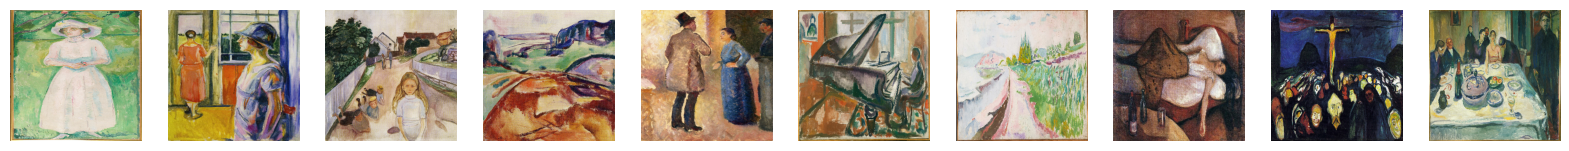

Reconstructions


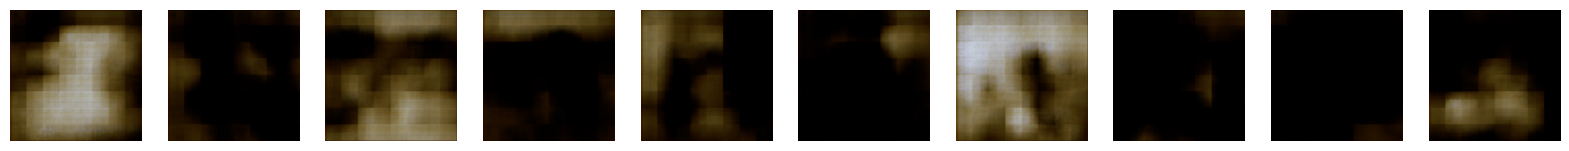

In [20]:
# Créer des prédictions de l'autoencodeur et les afficher
z_mean, z_log_var, reconstructions = vae.predict(example_images)

# Afficher les vrais visages de l'exemple
print("Exemples de vrais tableaux")
display(example_images)

# Afficher les reconstructions
print("Reconstructions")
display(reconstructions)

## Creation of new paintings

In [59]:
# Échantillonner des points dans l'espace latent à partir de la distribution normale standard
grid_width, grid_height = (10, 3)  # Dimensions de la grille d'échantillonnage
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))  # Générer des échantillons aléatoires dans l'espace latent

# Décoder les points échantillonnés
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 2s 2s/step


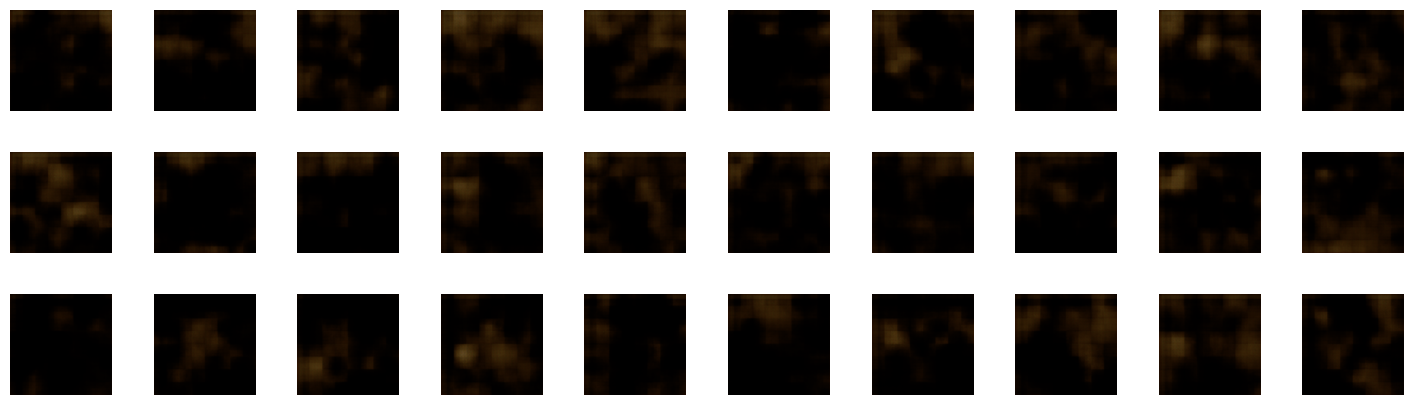

In [60]:
# Créer un graphique des images décodées
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Afficher la grille des visages générés
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")  # Désactiver les axes
    ax.imshow(reconstructions[i, :, :])  # Afficher l'image décodée

## Modification of the news faces

In [ ]:
# Charger l'ensemble de données d'étiquettes
attributes = pd.read_csv(data_dir + "/list_attr_celeba.csv")
print(attributes.columns)  # Afficher les noms des colonnes de l'ensemble de données
attributes.head()  # Afficher les premières lignes de l'ensemble de données

In [ ]:
# Charger les données de visages avec les étiquettes associées
LABEL = "Smiling"  # <- Définissez cette étiquette
labelled_test = utils.image_dataset_from_directory(
    data_dir + "/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

# Prétraiter les données d'images et d'étiquettes
labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

In [ ]:
# Trouver le vecteur d'attribut
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

In [ ]:
# Ajouter le vecteur aux images
add_vector_to_images(labelled, vae, attribute_vec)

In [ ]:
# Créer une interpolation entre deux images en fonction de facteurs
morph_faces(labelled, vae)

In [ ]:
# Charger les données de visages avec les étiquettes associées
LABEL = "Blond_Hair"  # <- Définissez cette étiquette
labelled_test = utils.image_dataset_from_directory(
    data_dir + "/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

# Prétraiter les données d'images et d'étiquettes
labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

In [ ]:
# Trouver le vecteur d'attribut
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

In [ ]:
# Ajouter le vecteur aux images
add_vector_to_images(labelled, vae, attribute_vec)